## Import Library

In [1]:
# Import Pustaka
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import os

# Konfigurasi visualisasi
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Data Preparation

### Load Data

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Muat Data
DRIVE_PATH = '/content/drive/MyDrive/Magang Prima PTKI/'

# Cek apakah path sudah benar
print(os.listdir(DRIVE_PATH))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['Train_Nukapos.ipynb', 'Nukapos.ipynb', '_producttosupplier.csv', 'cashier_cash.csv', 'cities.csv', 'customers.csv', 'districts.csv', 'payment_methods.csv', 'product_variant_options.csv', 'products.csv', 'provinces.csv', 'purchase_order_items.csv', 'purchase_orders.csv', 'roles.csv', 'shifts.csv', 'store_bills.csv', 'store_suppliers.csv', 'store_types.csv', 'store_users.csv', 'stores.csv', 'supplier_products.csv', 'suppliers.csv', 'taxes.csv', 'tenant_users.csv', 'tenants.csv', 'tokens.csv', 'transaction_details.csv', 'transactions.csv', 'user_activity.csv', 'users.csv', 'variant_options.csv', 'variant_types.csv', 'warehouse_stocks.csv', 'product_categories.csv']


In [3]:
# Fungsi untuk memuat hanya data inti forecasting
def load_core_forecasting_data(path):
    dfs = {}
    files = [
        'transactions.csv', 'transaction_details.csv', 'products.csv',
        'stores.csv', 'product_categories.csv'
    ]

    for file in files:
        df_name = file.replace('.csv', '')
        file_path = os.path.join(path, file)
        try:
            dfs[df_name] = pd.read_csv(file_path)
        except FileNotFoundError:
            print(f"Peringatan: File {file} tidak ditemukan.")

    return dfs

# Muat data
dfs = load_core_forecasting_data(DRIVE_PATH)
print("Data inti forecasting berhasil dimuat.")

Data inti forecasting berhasil dimuat.


### Data Cleaning

In [4]:
# Ambil DataFrame yang diperlukan
transactions_df = dfs['transactions'].copy()
details_df = dfs['transaction_details'].copy()
products_df = dfs['products'].copy()
stores_df = dfs['stores'].copy()

In [5]:
# 1. Cleaning Tipe Data Tanggal
transactions_df['transactionDate'] = pd.to_datetime(transactions_df['transactionDate'])
transactions_df['TransactionDate'] = transactions_df['transactionDate'].dt.date # Ambil hanya tanggal

In [6]:
# 2. Gabungkan Transaksi dan Detail
sales_combined = details_df.merge(transactions_df[['id', 'TransactionDate', 'storeId', 'status']],
                                  left_on='transactionId', right_on='id', suffixes=('_detail', '_trans'))


In [7]:
# 3. Cleaning: Filter hanya transaksi yang SUKSES (PAID)
sales_successful = sales_combined[sales_combined['status'] == 'PAID']

In [8]:
# 4. Agregasi Penjualan Harian (Struktur Data Dasar)
daily_sales = sales_successful.groupby(['TransactionDate', 'productId', 'storeId']) \
                              .agg(TotalQuantitySold=('quantity', 'sum'),
                                   TotalRevenue=('subtotal', 'sum')) \
                              .reset_index()

In [9]:
# 5. Gabungkan Atribut Produk dan Toko (Fitur Kategoris)
daily_sales = daily_sales.merge(products_df[['id', 'productCategoryId']],
                                left_on='productId', right_on='id', suffixes=('', '_prod'))
daily_sales = daily_sales.merge(stores_df[['id', 'storeTypeId']],
                                left_on='storeId', right_on='id', suffixes=('', '_store'))

In [10]:
# 6. Cleaning Akhir: Konversi Tipe Data & Hitung Avg Price
daily_sales['TransactionDate'] = pd.to_datetime(daily_sales['TransactionDate'])
daily_sales['AvgUnitPrice'] = daily_sales['TotalRevenue'] / daily_sales['TotalQuantitySold']

print("\nPembersihan dan Agregasi Data Harian Selesai.")
print(f"Total entri penjualan sukses yang diagregasi: {len(daily_sales)}")


Pembersihan dan Agregasi Data Harian Selesai.
Total entri penjualan sukses yang diagregasi: 421


## Exploratory Data Analysis

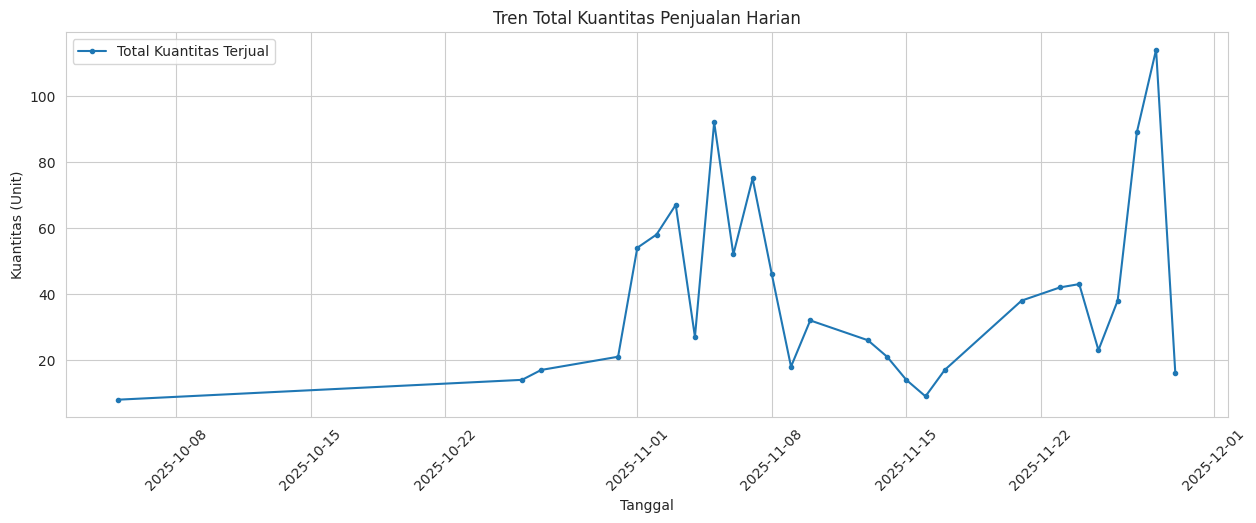

In [11]:
# --- EDA: Tren Penjualan Total ---
daily_totals = daily_sales.groupby('TransactionDate').agg(
    TotalQty=('TotalQuantitySold', 'sum'),
    TotalRev=('TotalRevenue', 'sum')
).reset_index()

plt.figure(figsize=(15, 5))
plt.plot(daily_totals['TransactionDate'], daily_totals['TotalQty'], label='Total Kuantitas Terjual', marker='o', markersize=3)
plt.title('Tren Total Kuantitas Penjualan Harian')
plt.xlabel('Tanggal')
plt.ylabel('Kuantitas (Unit)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

/tmp/ipython-input-3221771751.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='DayOfWeek', y='TotalQuantitySold', data=daily_sales, ci=None)


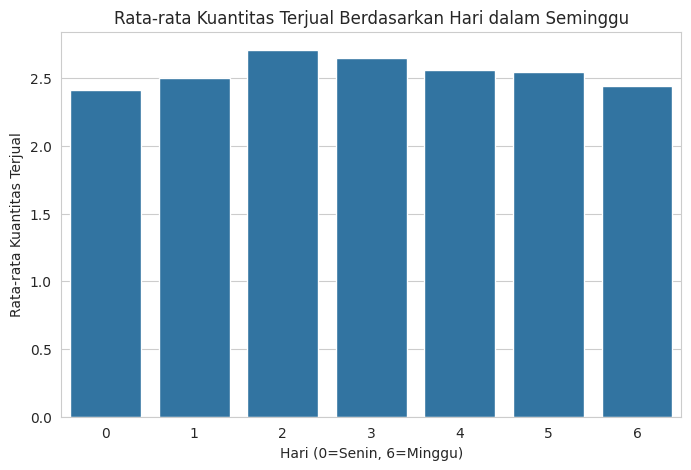

In [12]:
# --- EDA: Pola Mingguan ---
daily_sales['DayOfWeek'] = daily_sales['TransactionDate'].dt.dayofweek # 0=Senin, 6=Minggu
plt.figure(figsize=(8, 5))
sns.barplot(x='DayOfWeek', y='TotalQuantitySold', data=daily_sales, ci=None)
plt.title('Rata-rata Kuantitas Terjual Berdasarkan Hari dalam Seminggu')
plt.xlabel('Hari (0=Senin, 6=Minggu)')
plt.ylabel('Rata-rata Kuantitas Terjual')
plt.show()

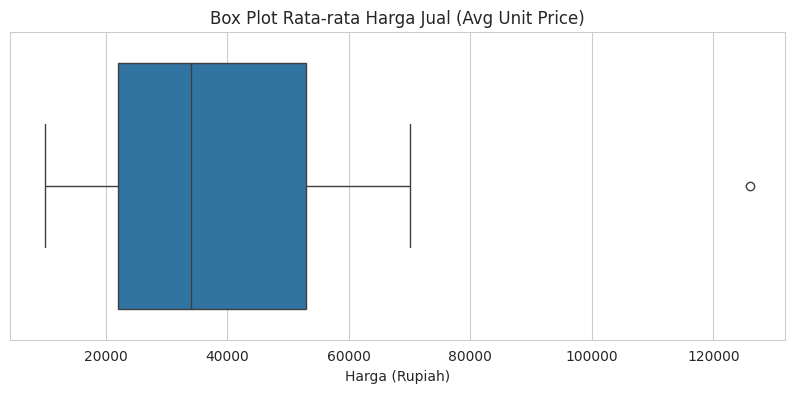


EDA Selesai. Pola mingguan dan tren terkonfirmasi.


In [13]:
# --- EDA: Distribusi Harga (Outlier Check) ---
plt.figure(figsize=(10, 4))
sns.boxplot(x='AvgUnitPrice', data=daily_sales)
plt.title('Box Plot Rata-rata Harga Jual (Avg Unit Price)')
plt.xlabel('Harga (Rupiah)')
plt.show()

print("\nEDA Selesai. Pola mingguan dan tren terkonfirmasi.")

## Preprocessing Data

In [14]:
# --- 1. Pra-pemrosesan Data (Finalisasi Fitur) ---
print("\nMemulai Zero Imputation dan Final Feature Engineering...")

# 1. Tentukan Kerangka Waktu Lengkap (Zero Imputation)
all_dates = pd.date_range(start=daily_sales['TransactionDate'].min(),
                          end=daily_sales['TransactionDate'].max(),
                          freq='D')
all_products = daily_sales['productId'].unique()
all_stores = daily_sales['storeId'].unique()

complete_index = pd.MultiIndex.from_product(
    [all_dates, all_products, all_stores],
    names=['TransactionDate', 'productId', 'storeId']
)
daily_sales_indexed = daily_sales.set_index(['TransactionDate', 'productId', 'storeId'])
daily_sales_complete = daily_sales_indexed.reindex(complete_index).reset_index()


Memulai Zero Imputation dan Final Feature Engineering...


In [15]:
# 2. Imputasi Target & Harga
# Imputasi TotalQuantitySold dan TotalRevenue dengan Nol
daily_sales_complete['TotalQuantitySold'] = daily_sales_complete['TotalQuantitySold'].fillna(0)
daily_sales_complete['TotalRevenue'] = daily_sales_complete['TotalRevenue'].fillna(0)

In [16]:
# Imputasi Atribut Kategoris (ffill/bfill untuk storeTypeId/productCategoryId)
attribute_cols = ['productCategoryId', 'storeTypeId']
for col in attribute_cols:
    daily_sales_complete[col] = daily_sales_complete.groupby(['productId', 'storeId'])[col].ffill().bfill()

In [17]:
# Hitung ulang AvgUnitPrice, memastikan pembagian dengan nol menghasilkan 0
daily_sales_complete['AvgUnitPrice'] = np.where(
    daily_sales_complete['TotalQuantitySold'] == 0,
    0, # JIKA KUANTITAS NOL, HARGA RATA-RATA JUGA NOL
    daily_sales_complete['TotalRevenue'] / daily_sales_complete['TotalQuantitySold']
)

In [18]:
# Konversi Tanggal dan cleaning awal
daily_sales_clean = daily_sales_complete.dropna().copy()
daily_sales_clean['TransactionDate'] = pd.to_datetime(daily_sales_clean['TransactionDate'])

print("Zero Imputation Selesai.")

Zero Imputation Selesai.


In [19]:
# --- 2. Rekayasa Fitur Temporal dan Lag ---
daily_sales_clean['DayOfWeek'] = daily_sales_clean['TransactionDate'].dt.dayofweek
daily_sales_clean['IsWeekend'] = daily_sales_clean['DayOfWeek'].isin([5, 6]).astype(int)
daily_sales_clean['IsMonthStartEnd'] = daily_sales_clean['TransactionDate'].dt.day.apply(
    lambda x: 1 if (x <= 7) or (x >= 25) else 0
)

In [20]:
# Fitur Lag (Penjualan Seminggu Lalu)
daily_sales_clean['QuantityLag7'] = daily_sales_clean.groupby(['productId', 'storeId'])['TotalQuantitySold'].shift(7)

In [21]:
# Fitur Rolling Window (Rata-rata 7 hari sebelumnya)
daily_sales_clean['AvgQty7D'] = daily_sales_clean.groupby(['productId', 'storeId'])['TotalQuantitySold'].transform(
    lambda x: x.rolling(window=7).mean().shift(1)
)

In [22]:
# Hapus baris NaN setelah Lag dan Rolling Window (7 hari pertama)
daily_sales_final = daily_sales_clean.dropna().copy()

In [23]:
# --- 3. Encoding Kategoris dan Pembagian Data ---
# Kolom kategoris: storeId, productId, storeTypeId, productCategoryId
categorical_features = ['storeId', 'productId', 'storeTypeId', 'productCategoryId']

In [24]:
# One-Hot Encoding untuk storeTypeId dan productCategoryId
X = daily_sales_final.drop(columns=['TotalQuantitySold', 'TransactionDate', 'TotalRevenue', 'AvgUnitPrice'])
y = daily_sales_final['TotalQuantitySold']

X_encoded = pd.get_dummies(X, columns=['storeTypeId', 'productCategoryId'], drop_first=True)

In [25]:
# Drop kolom ID (storeId, productId)
X_final = X_encoded.drop(columns=['storeId', 'productId'], errors='ignore')